In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from typing import Union

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm

from imblearn.under_sampling import RandomUnderSampler

from src.data.ucmerced_dataset import UcMercedDataset
from src.measures import anmrr
from src.settings import TRAIN_DATA_DIRECTORY, TEST_DATA_DIRECTORY, RANDOM_WALKS_DIRECTORY

In [3]:
train_dataset = UcMercedDataset(TRAIN_DATA_DIRECTORY)
test_dataset = UcMercedDataset(TEST_DATA_DIRECTORY)

In [4]:
x_train = np.empty(shape=(train_dataset.__len__(), 256, 256, 3))
y_train = np.empty(shape=(train_dataset.__len__(), ), dtype=np.int)

x_test = np.empty(shape=(test_dataset.__len__(), 256, 256, 3))
y_test = np.empty(shape=(test_dataset.__len__(), ), dtype=np.int)

for idx in trange(train_dataset.__len__()):
    item = train_dataset.__getitem__(idx)

    x_train[idx] = item['a']
    y_train[idx] = item['a_y']

for idx in trange(test_dataset.__len__()):
    item = test_dataset.__getitem__(idx)

    x_test[idx] = item['a']
    y_test[idx] = item['a_y']

100%|██████████| 411/411 [00:03<00:00, 120.33it/s]


In [5]:
sift = cv2.SIFT_create()

In [6]:
def get_descriptors(
        images: np.ndarray,
        labels: Union[np.ndarray, None] = None
):
    desc = []
    matching_labels = []

    for idx, img in tqdm(
            enumerate(images),
            desc="Calculating SIFT descriptors",
            total=images.shape[0]
    ):
        cv_img = img_as_ubyte(img)
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)
        _, d = sift.detectAndCompute(cv_img, None)
        if d is not None:
            desc.append(d)

            if labels is not None:
                matching_labels.append(np.repeat(labels[idx], len(d)))

    if labels is not None:
        return desc, matching_labels
    else:
        return desc

def encode_as_bovw(x: np.ndarray, trained_kmeans: KMeans) -> np.ndarray:
    descriptors = get_descriptors(x)

    res = np.empty(shape=(x.shape[0], trained_kmeans.n_clusters))

    for idx, desc in tqdm(
            enumerate(descriptors),
            total=len(descriptors),
            desc="Encoding as BOVW"):
        words = trained_kmeans.predict(desc)
        bovw, _ = np.histogram(words, bins=range(trained_kmeans.n_clusters + 1))
        res[idx] = bovw / desc.shape[0]

    return res

In [7]:
x_train_descriptors, y_train_descriptors = get_descriptors(x_train, y_train)
stacked_train_descriptors = np.vstack(x_train_descriptors)
stacked_train_labels = np.hstack(y_train_descriptors)

Calculating SIFT descriptors: 100%|██████████| 1645/1645 [01:22<00:00, 19.96it/s]


In [8]:
np.unique(stacked_train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([ 70423,  35104,  20162,  19316,  56740, 130831,  76489,  98883,
         38381,  22757,  69595,  55545,  72026,  67430,  28992,  82127,
         54335,  15893,  57951,  33564,  50548]))

In [9]:
under_sampler = RandomUnderSampler(random_state=42)

resampled_train_descriptors, resampled_train_labels = under_sampler.fit_resample(stacked_train_descriptors, stacked_train_labels)

In [10]:
np.unique(resampled_train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([15893, 15893, 15893, 15893, 15893, 15893, 15893, 15893, 15893,
        15893, 15893, 15893, 15893, 15893, 15893, 15893, 15893, 15893,
        15893, 15893, 15893]))

In [21]:
CLUSTERS = 100
SAMPLES_COUNT = 100000

In [22]:
samples_ratio_for_kmeans = SAMPLES_COUNT / resampled_train_descriptors.shape[0]

_, descriptors_for_kmeans, _, labels_for_kmeans = train_test_split(
    resampled_train_descriptors,
    resampled_train_labels,
    test_size=samples_ratio_for_kmeans
)

In [23]:
np.unique(labels_for_kmeans, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([4808, 4805, 4734, 4759, 4766, 4717, 4685, 4822, 4846, 4648, 4683,
        4680, 4885, 4733, 4777, 4843, 4787, 4705, 4746, 4795, 4776]))

In [24]:
%%time

k_means = KMeans(n_clusters=CLUSTERS)

k_means.fit(descriptors_for_kmeans)


CPU times: user 15min 23s, sys: 5min 37s, total: 21min
Wall time: 6min


KMeans(n_clusters=100)

In [25]:
x_test_encoded = encode_as_bovw(x_test, k_means)

Encoding as BOVW: 100%|██████████| 410/410 [00:13<00:00, 30.76it/s]


In [26]:
anmrr(x_test_encoded, y_test[:, None], euclidean_distances)

0.6610559872719973

In [27]:
n_neighbours = NearestNeighbors()
n_neighbours.fit(x_test_encoded)

NearestNeighbors()

In [28]:
QUERY_IMAGE_IDX = 162

In [29]:
query_image = x_test_encoded[QUERY_IMAGE_IDX].reshape(1, -1)
_, query_result_idx = n_neighbours.kneighbors(query_image, n_neighbors=11)

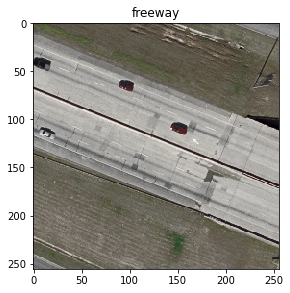

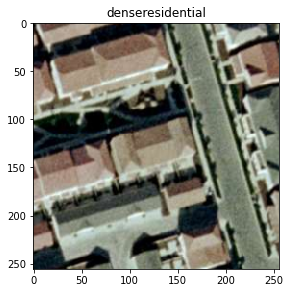

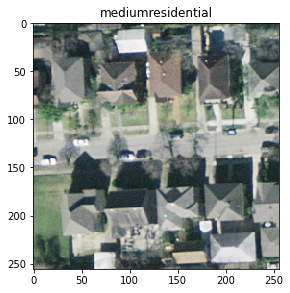

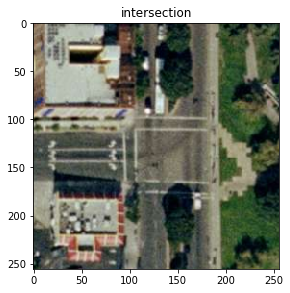

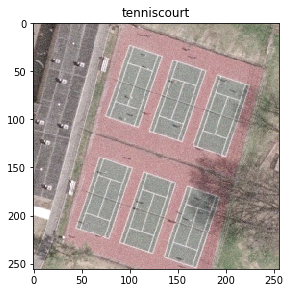

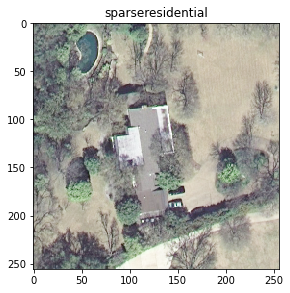

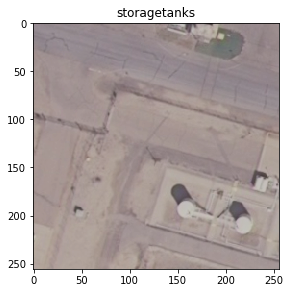

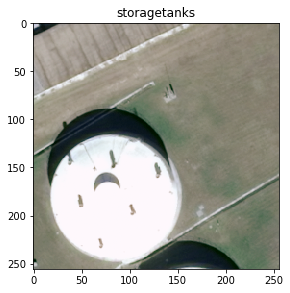

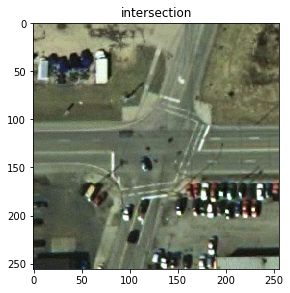

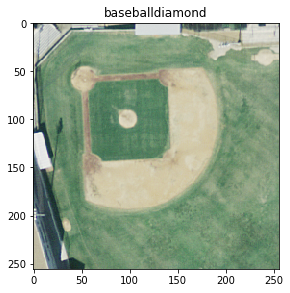

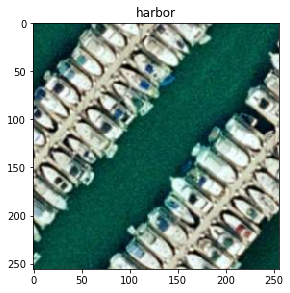

In [30]:
for idx in query_result_idx.squeeze():
    io.imshow(x_test[idx])
    plt.title(test_dataset.label_name_mapping[y_test[idx]])
    plt.show()

In [54]:
import imageio
from src.visualisation import random_walk

In [56]:
random_walk(
    images=x_test,
    images_encoded=x_test_encoded,
    trained_n_neighbours=n_neighbours,
    search_range=15,
    starting_index=106,
    filename_prefix="uc_merced_classic_"
)

Done walking
